In [2]:
from transformers import BertForSequenceClassification

sc_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

print(sc_model.state_dict().keys())


/Users/aiant/AI_project/ai_venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

In [4]:
# 최적화 알고리즘을 AdamW로 사용
# AdamW는 Adam optimizer에 weight decay를 추가한 것
# weight decay는 모델의 가중치가 너무 커지지 않도록 제한함
from torch.optim import AdamW
optimizer = AdamW(sc_model.parameters(), lr=1e-5) # lr은 학습률


In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentences = ["I love baseball.", "I hate baseball."]
tokenized = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
print(tokenized)

x = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

/Users/aiant/AI_project/ai_venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'input_ids': tensor([[ 101, 1045, 2293, 3598, 1012,  102],
        [ 101, 1045, 5223, 3598, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}


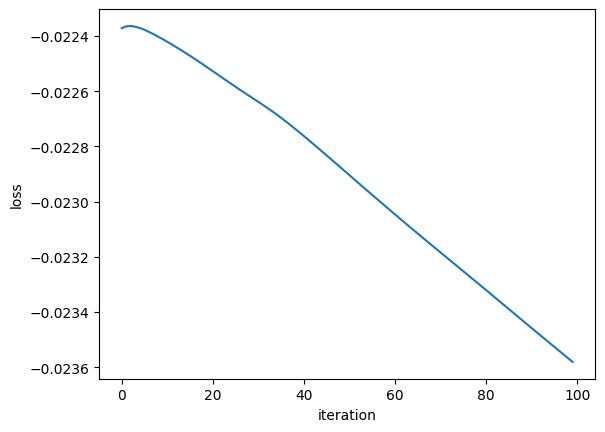

In [6]:
# 간단한 파인튜닝 구현
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

sc_model.train()
t = torch.tensor([1, 0]) # 레이블
weight_record = []

for i in range(100):
    y = sc_model(x, attention_mask=attention_mask)
    loss = F.cross_entropy(y.logits, t)
    loss.backward()
    optimizer.step()
    weight = sc_model.state_dict()["bert.encoder.layer.11.output.dense.weight"][0][0].item()
    weight_record.append(weight)
    
plt.plot(range(len(weight_record)), weight_record)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()


## 파인튜닝을 사용한 감정 분석

In [7]:
from transformers import BertTokenizerFast, BertForSequenceClassification

sc_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/Users/aiant/AI_project/ai_venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

In [8]:
from nlp import load_dataset

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_data, eval_data = load_dataset("imdb", split=['train', 'test[:20%]'])

print(train_data["label"][0], train_data["text"][0])
print(train_data["label"][20000], train_data["text"][20000])


Downloading: 100%|██████████| 4.56k/4.56k [00:00<00:00, 2.99MB/s]
Downloading: 100%|██████████| 2.07k/2.07k [00:00<00:00, 4.49MB/s]


Downloading: 100%|██████████| 84.1M/84.1M [00:10<00:00, 7.73MB/s]


Dataset imdb downloaded and prepared to /Users/aiant/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.
1 Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pit

In [9]:
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
train_data.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

eval_data = eval_data.map(tokenize, batched=True, batch_size=len(eval_data))
eval_data.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


In [10]:
from sklearn.metrics import accuracy_score

def compute_metrics(result):
    labels = result.label_ids
    preds = result.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [11]:
# training arguments 설정

from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results', # 출력 디렉터리
    logging_dir='./logs', # 경과 로그를 기록할 디렉터리
    num_train_epochs=1, # 학습 에폭 수
    per_device_train_batch_size=8, # 학습 시 배치 크기
    per_device_eval_batch_size=32, # 평가 시 배치 크기
    warmup_steps=500, # 학습 계수가 이 단계만큼 선형적으로 증가
    weight_decay=0.01, # 가중치 감쇠 계수
    evaluation_strategy="steps", # 훈련 중 일정 단계마다 계산
)



In [12]:
from transformers import Trainer

trainer = Trainer(
    model=sc_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=eval_data
)


In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
sc_model.to(device)

trainer = Trainer(
    model=sc_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=eval_data,
)

Using device: mps


In [16]:
trainer.train()

/Users/aiant/AI_project/ai_venv/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 109483778


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()